# RUN PERFORMANCE PROJECT - Pau Sampietro

## Introductory application of unsupervised learning algorithms (Clustering moves)

_EXPLANATION_

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.plotly as py
import matplotlib.pyplot as plt
import cufflinks as cf 
from ipywidgets import interact
import plotly.graph_objs as go
from rpdb import read_table, read_table_sql, export_table

#### Importing data from tables stored in the DB

To work on this part, we only import the relevant and not redundant columns of the records table. (waiting time: ~ 1 min)

In [2]:
Ssql = """SELECT idmove, idrecord, enhanced_altitude, vertical_speed, records.heart_rate, records.pace, athlete
         FROM records INNER JOIN moves ON move = idmove
         WHERE athlete = 'P'"""

# Function created for this purpose, that imports data with specific select query 
records = read_table_sql('records', Ssql)

In [3]:
records.head()

,idmove,idrecord,enhanced_altitude,vertical_speed,heart_rate,pace,athlete
0,1,6,133.0,0.0,110.0,7.94,P
1,1,7,133.0,0.0,110.0,7.94,P
2,1,8,133.0,0.0,110.0,6.67,P
3,1,9,134.0,0.0,110.0,6.67,P
4,1,10,134.0,0.0,110.0,6.41,P


### 1. Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. heart rate compared to pace and vertical_speed). Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through **feature scaling**. We'll use this technique again with this dataset.

In [4]:
from sklearn.preprocessing import StandardScaler

In [74]:
scaler = StandardScaler()

# Subsampling to not running out of memory
records_feat = records[['enhanced_altitude', 'vertical_speed', 'heart_rate', 'pace']]
records_feat = records_feat.sample(100000)

records_sc = scaler.fit_transform(records_feat)

In [75]:
pd.DataFrame(records_sc).head()

,0,1,2,3
0,-0.592450,-0.277647,-0.698105,-0.284874
1,-0.219855,-2.282889,0.957018,-0.515097
2,-0.217428,-0.528302,-0.808446,-0.413864
3,-0.326354,0.912966,0.294969,-0.284874
4,-0.380362,0.599647,0.239798,-0.108534


### 2. Data Clustering with K-Means algorithm

In [76]:
from sklearn.cluster import KMeans

In [78]:
# Instantiate the model and fit records features once they have been scaled
km_model = KMeans(n_clusters=4)
km_fit = km_model.fit(X=records_sc)

# We add a column with the labels provided by the algorithm
records_feat['kmeans_cluster'] = km_model.labels_

In [79]:
records_feat['kmeans_cluster'].value_counts()

1    51523
3    34401
0    10349
2     3727
Name: kmeans_cluster, dtype: int64

### 3. Data Clustering with DBSCAN algorithm

In [32]:
from sklearn.cluster import DBSCAN

In [80]:
# Instantiate the model and fit records features once they have been scaled
dbscan_model = DBSCAN(eps=0.5, min_samples=6)
dbscan_model.fit(records_sc)

# We add a column with the labels provided by the algorithm
records_feat['dbscan_cluster'] = dbscan_model.labels_

In [83]:
records_feat['dbscan_cluster'].value_counts().head()

 0     95460
 3      1072
-1       955
 4       480
 13      465
Name: dbscan_cluster, dtype: int64

### 4. Visualization of Clusters and performing some Metrics

#### 4.1. Metrics for raw clustering with both models

In [11]:
from sklearn.metrics import silhouette_score

In [95]:
km_sc = silhouette_score(records_feat, labels = km_model.labels_, metric='euclidean')

In [96]:
db_sc = silhouette_score(records_feat, labels = dbscan_model.labels_ , metric='euclidean')

In [97]:
print(f'Score for K-Means Clustering: Silouhette score = {km_sc}')
print(f'Score for DBSCAN Clustering: Silouhette score = {db_sc}')

Score for K-Means Clustering: Silouhette score = 0.057202244647849065
Score for DBSCAN Clustering: Silouhette score = -0.8050784046747588


#### 4.2. Visualization in scatter plots of clusters done with both algorithms

# HERE WE HAVE TO DO SUBPLOTS WITH BOTH SCATTERPLORS: KMEANS AND DBSCAN. CHOOSE/TEST VARIABLES X and Y!!!

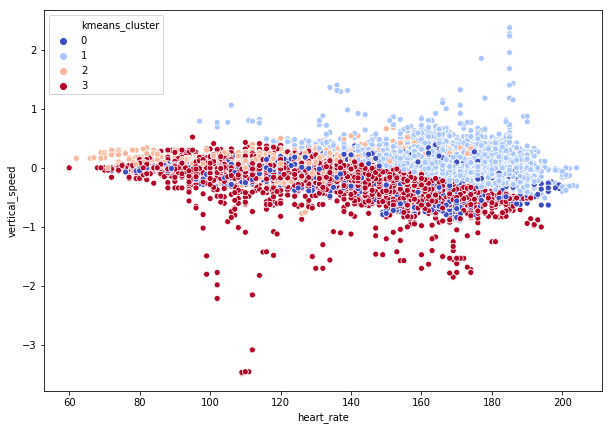

In [84]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='heart_rate',y='vertical_speed',data=records_feat ,hue='kmeans_cluster',palette="coolwarm")
plt.show()

# 3D scatter to see clusters!!!!

In [85]:
from mpl_toolkits.mplot3d import Axes3D

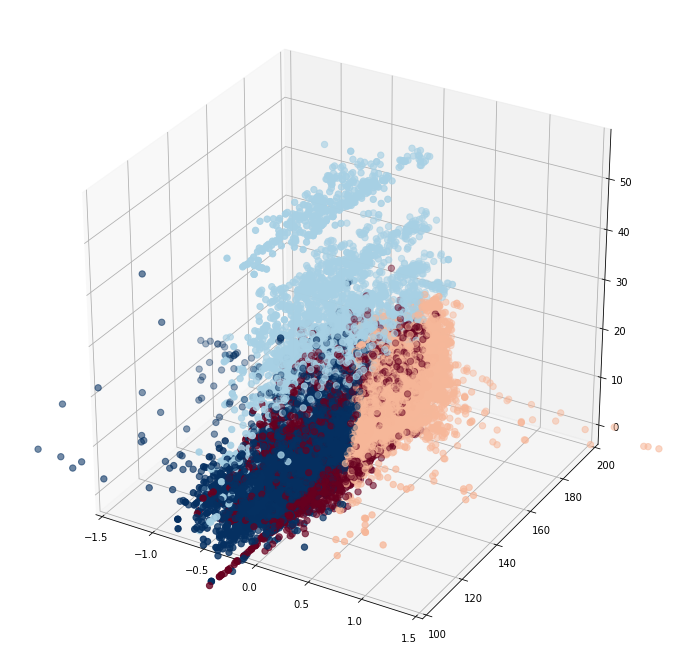

In [89]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
x = np.array(records_feat.pace)
y = np.array(records_feat.heart_rate)
z = np.array(records_feat.vertical_speed)

ax.scatter(z,y,x, marker="o", c=records_feat.kmeans_cluster, s=40, cmap="RdBu")
plt.xlim(-1.5,1.5)
plt.ylim(100,200)
plt.show()

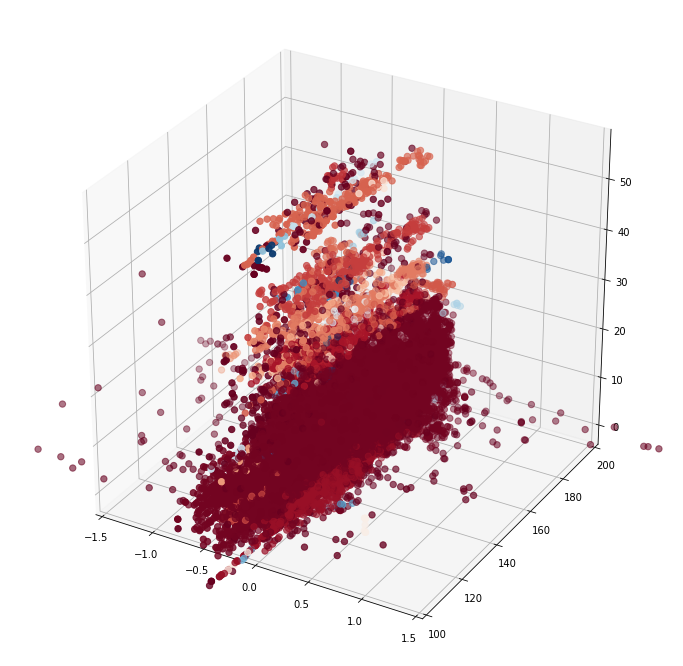

In [90]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
x = np.array(records_feat.pace)
y = np.array(records_feat.heart_rate)
z = np.array(records_feat.vertical_speed)

ax.scatter(z,y,x, marker="o", c=records_feat.dbscan_cluster, s=40, cmap="RdBu")
plt.xlim(-1.5,1.5)
plt.ylim(100,200)
plt.show()